In [1]:
from causallib.datasets import load_nhefs,load_card_krueger
def load_lalonde_local(limit_to=None):
    from sklearn.utils import Bunch
    lalonde = pd.read_csv("~/lalonde_data.csv")
    if limit_to:
        lalonde = lalonde.sample(limit_to)
        lalonde = lalonde.loc[:, (lalonde != 0).any(axis=0)]
    lalonde = lalonde[[i for i in lalonde.columns if "education" not in i]]
    lalonde = lalonde.set_index("sample_id")
    a = lalonde.pop("training").astype(int)
    y = lalonde.pop("re78")
    X = lalonde
    return Bunch(X=X,a=a,y=y)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from causallib.estimation import Matching,MatchingIndividualOutcomeEstimator,MatchingTransformer
from causallib.estimation import faiss_knn_wrapper 
from causallib.preprocessing.transformers import PropensityTransformer
from sklearn.linear_model import LogisticRegression
import faiss
%load_ext autoreload
%autoreload 2

In [2]:
data = load_lalonde_local()
X,a,y = data.X,data.a,data.y

In [3]:
Xaprop = PropensityTransformer(learner=LogisticRegression(solver="liblinear",class_weight="balanced")).fit(X,a).transform(X).join(a)[["propensity","training"]]

In [74]:
Xaprop.groupby("training").mean()

,propensity
training,
0,0.149679
1,0.850449


In [5]:
learner = lambda : LogisticRegression(solver="liblinear",max_iter=5000,class_weight="balanced")
proptrans=PropensityTransformer(learner=learner(),include_covariates=True)
m=Matching(propensity_transform=proptrans,caliper=0.001).fit(X,a,y)
m.estimate_population_outcome(X,a,y)

0    8655.246013
1    7278.533109
dtype: float64

<AxesSubplot:>

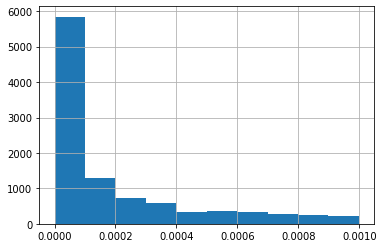

In [6]:
m.get_covariates_of_matches(1,0,X).match.distance.hist()

In [7]:
index = faiss.IndexFlatL2(X.shape[1])
index.add(np.ascontiguousarray(X.values).astype("float32"))

In [8]:
%timeit index.search(np.ascontiguousarray(X.values).astype("float32"),2)

1.16 s ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
nlist = 100
k = 4
d = X.shape[1]
quantizer = faiss.IndexFlatL2(d)  # the other index
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(np.ascontiguousarray(X.values.astype("float32")))
assert index.is_trained
index.add(np.ascontiguousarray(X.values.astype("float32")))

In [10]:
index.nprobe = 1
%timeit index.search(np.ascontiguousarray(X.values).astype("float32"),10)

119 ms ± 8.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
index.nprobe = 10
%timeit index.search(np.ascontiguousarray(X.values).astype("float32"),2)

122 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
from sklearn.covariance import EmpiricalCovariance
EmpiricalCovariance().fit(np.random.random(10)[:,np.newaxis]).covariance_

array([[0.08031266]])

In [13]:
pd.DataFrame(pd.Series(np.arange(100))).values.shape

(100, 1)

In [ ]:
def test_backend(backend="sklearn"):
    m = Matching(knn_backend=backend,n_neighbors=3,metric="euclidean")
    m.fit(X,a,y)
    Y = m.estimate_population_outcome(X,a,y)
    print(Y[1] - Y[0])
    return m.match_df_

In [26]:
mivf = test_backend("faiss_ivfflat")
msk =  test_backend("sklearn")
mfl2 = test_backend("faiss_flatl2")

allmatches = mivf.join(msk,rsuffix="sk",lsuffix="ivf").join(mfl2,rsuffix="fl2")
allmatches1to0 = allmatches.loc[0][allmatches.loc[0].join(a).training==1]
allmatches0to1 = allmatches.loc[1][allmatches.loc[1].join(a).training==0]

-6817.958665665416


In [37]:
allmatches1to0.loc[(allmatches1to0.matches.apply(lambda x: tuple(sorted(x))) != allmatches1to0.matchesivf.apply(lambda x: tuple(sorted(x))))]

,distancesivf,matchesivf,distancessk,matchessk,distances,matches
sample_id,,,,,,
180,"[273.87527, 311.03854, 340.40643]","[3394, 16402, 19962]","[273.8757216330068, 311.03807162468036, 340.40...","[3394, 16402, 19962]","[273.8759, 311.07556, 340.44678]","[3394, 16402, 11469]"
90,"[0.0, 0.0, 1.0]","[15779, 288, 5807]","[0.0, 0.0, 1.0]","[15779, 288, 22104]","[0.0, 0.0, 1.0]","[15779, 288, 14658]"
51,"[0.0, 0.0, 1.0]","[15779, 288, 5807]","[0.0, 0.0, 1.0]","[15779, 288, 22104]","[0.0, 0.0, 1.0]","[15779, 288, 14658]"
18,"[1.0, 1.0, 1.0]","[10989, 21579, 21468]","[1.0, 1.0, 1.0]","[13936, 21468, 10989]","[1.0, 1.0, 1.0]","[10989, 13936, 21468]"


In [32]:
allmatches0to1

,distancesivf,matchesivf,distancessk,matchessk,distances,matches
sample_id,,,,,,
16827,"[77.270775, 77.270775, 77.277245]","[19, 95, 34]","[77.27077670595074, 77.27077670595074, 77.2772...","[95, 19, 87]","[77.270775, 77.270775, 77.277245]","[19, 95, 34]"
5412,"[2724.498, 4695.949, 5220.586]","[182, 180, 183]","[2724.4980468702856, 4695.949451655118, 5220.5...","[182, 180, 183]","[2724.4905, 4695.9385, 5220.587]","[182, 180, 183]"
15399,"[449.90527, 1060.3557, 1225.269]","[149, 153, 142]","[449.9053638099909, 1060.355763939631, 1225.26...","[149, 153, 142]","[449.89777, 1060.3584, 1225.2673]","[149, 153, 142]"
13077,"[3259.7544, 3858.9976, 10671.215]","[174, 180, 133]","[3259.7541578431965, 3858.9973933077467, 10671...","[174, 180, 133]","[3259.762, 3858.9863, 10671.211]","[174, 180, 133]"
2189,"[7.1414285, 9.055386, 9.165152]","[31, 38, 71]","[7.14142842854285, 9.055385138137417, 9.165151...","[31, 38, 71]","[7.1414285, 9.055386, 9.165152]","[31, 38, 71]"
...,...,...,...,...,...,...
11964,"[1422.3102, 1461.2595, 1746.076]","[164, 162, 140]","[1422.3100723938508, 1461.2593259065968, 1746....","[164, 162, 140]","[1422.3024, 1461.2653, 1746.0768]","[164, 162, 140]"
21575,"[0.0, 0.0, 0.0]","[42, 47, 46]","[0.0, 0.0, 0.0]","[46, 55, 42]","[0.0, 0.0, 0.0]","[42, 47, 46]"
5390,"[4108.965, 4205.809, 4412.1333]","[133, 141, 151]","[4108.964819037028, 4205.808497716461, 4412.13...","[133, 141, 151]","[4108.9717, 4205.813, 4412.136]","[133, 141, 151]"


In [60]:
from sklearn.datasets import make_classification
x, a = make_classification(
            n_features=3,
            n_samples=500,
            n_informative=2,
            n_redundant=0,
            n_repeated=0,
            n_classes=2,
            n_clusters_per_class=1,
            flip_y=0.0,
            class_sep=1.0,
            random_state=5432,
        )
x = (
            pd.DataFrame(x)
            .assign(treatment=a)
            .assign(outcome=x @ (0.1, 0.2, 0.3) + 5 * a)
        )
a = x.pop("treatment")
y = x.pop("outcome")
x.columns = [f"x{i}" for i in range(len(x.columns))]
def test_backend(backend="sklearn"):
    m = Matching(knn_backend=backend,n_neighbors=3,metric="euclidean")
    m.fit(x,a,y)
    Y = m.estimate_population_outcome(x,a,y)
    print(Y[1] - Y[0])
    return m.match_df_

In [61]:
mivf = test_backend("faiss_ivfflat")
msk =  test_backend("sklearn")
mfl2 = test_backend("faiss_flatl2")

allmatches = mivf.join(msk,rsuffix="sk",lsuffix="ivf").join(mfl2,rsuffix="fl2")
allmatches1to0 = allmatches.loc[0][allmatches.loc[0].join(a).treatment==1]
allmatches0to1 = allmatches.loc[1][allmatches.loc[1].join(a).treatment==0]

4.669280510988401
4.669280510988401
4.669280510988401


In [59]:
allmatches0to1


,distancesivf,matchesivf,distancessk,matchessk,distances,matches
sample_id,,,,,,
1,"[6.4554067, 6.5622897, 6.5640063]","[64, 24, 232]","[6.455406682797078, 6.562289216697217, 6.56400...","[64, 24, 232]","[6.4554067, 6.562289, 6.564006]","[64, 24, 232]"
2,"[4.570979, 4.6929183, 4.707032]","[24, 232, 64]","[4.570979256999741, 4.692918233262011, 4.70703...","[24, 232, 64]","[4.570979, 4.6929183, 4.707032]","[24, 232, 64]"
6,"[4.093994, 4.2224207, 4.254366]","[24, 232, 64]","[4.093994088036548, 4.222420437191992, 4.25436...","[24, 232, 64]","[4.093994, 4.2224207, 4.254366]","[24, 232, 64]"
7,"[5.845313, 5.965486, 5.9669003]","[64, 361, 373]","[5.845313220150424, 5.965486195009657, 5.96690...","[64, 361, 373]","[5.845313, 5.965486, 5.9669003]","[64, 361, 373]"
8,"[4.326772, 4.384822, 4.4000688]","[24, 64, 232]","[4.326771967450851, 4.384821775839641, 4.40006...","[24, 64, 232]","[4.3267717, 4.384822, 4.400069]","[24, 64, 232]"
...,...,...,...,...,...,...
491,"[5.0047674, 5.101507, 5.1181192]","[64, 361, 232]","[5.004767618234948, 5.101507057050451, 5.11811...","[64, 361, 232]","[5.0047674, 5.101507, 5.1181192]","[64, 361, 232]"
492,"[5.226806, 5.2371893, 5.283604]","[64, 24, 232]","[5.2268064724665715, 5.237189194945973, 5.2836...","[64, 24, 232]","[5.226806, 5.2371893, 5.2836037]","[64, 24, 232]"
494,"[3.4005675, 3.6704743, 3.8345392]","[24, 232, 64]","[3.4005674911317336, 3.6704743364769072, 3.834...","[24, 232, 64]","[3.4005675, 3.6704745, 3.8345392]","[24, 232, 64]"


In [83]:
    def test_all_backends_agree():
        test_matching.TestMatching.setUpClass()

        self = test_matching.TestMatching()
        selfmatching = Matching()
        selfmatching.n_neighbors = 3

        for data_identifier in self.data_identifiers:
            x, a, y = self.get_data(data_identifier)
            print(data_identifier)
            def get_estimate_for_backend(backend, metric):
                selfmatching.knn_backend = backend
                selfmatching.metric = metric
                selfmatching.fit(x, a, y)
                Y = selfmatching.estimate_population_outcome(x, a, y)
                return Y.values
            euclidean_results, mahalanobis_results = [[], []]
            for backend in ["sklearn", "faiss_ivfflat", "faiss_flatl2"]:
                print("\t"+backend)
                euclidean_results.append(
                    get_estimate_for_backend(backend, "euclidean"))
                mahalanobis_results.append(
                    get_estimate_for_backend(backend, "mahalanobis"))
            euclidean_results = np.array(euclidean_results)
            mahalanobis_results = np.array(mahalanobis_results)
            np.testing.assert_allclose(
                euclidean_results - euclidean_results[0], 0)
            np.testing.assert_allclose(
                mahalanobis_results - mahalanobis_results[0], 0)
            print(euclidean_results)
            print(euclidean_results - euclidean_results[0])
            print(mahalanobis_results)
            print(mahalanobis_results - mahalanobis_results[0])
            

In [84]:
test_all_backends_agree()

serial_covariates
	sklearn
	faiss_ivfflat
	faiss_flatl2
[[0.49240218 1.00883318]
 [0.49240218 1.00883318]
 [0.49240218 1.00883318]]
[[0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.49240218 1.00883318]
 [0.49240218 1.00883318]
 [0.49240218 1.00883318]]
[[0. 0.]
 [0. 0.]
 [0. 0.]]
serial_covariates_unbalanced_treatments
	sklearn
	faiss_ivfflat
	faiss_flatl2
[[45.41818182 14.72727273]
 [45.41818182 14.72727273]
 [45.41818182 14.72727273]]
[[0. 0.]
 [0. 0.]
 [0. 0.]]
[[45.41818182 14.72727273]
 [45.41818182 14.72727273]
 [45.41818182 14.72727273]]
[[0. 0.]
 [0. 0.]
 [0. 0.]]
3_feature_linear_effect
	sklearn
	faiss_ivfflat
	faiss_flatl2
[[0.27561882 4.94489933]
 [0.27561882 4.94489933]
 [0.27561882 4.94489933]]
[[0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.24000802 4.91033677]
 [0.24000802 4.91033677]
 [0.24000802 4.91033677]]
[[0. 0.]
 [0. 0.]
 [0. 0.]]


<causallib.tests.test_matching.TestMatching testMethod=runTest>